In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [21]:
df_usuarios = pd.read_csv('usuarios_novo.csv', sep=';')
df_abordagem = pd.read_csv('abordagem_novo.csv', sep=';', low_memory=False)

C:\Users\dpalo\AppData\Local\Temp\ipykernel_9340\274402894.py:1: DtypeWarning: Columns (15,16,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usuarios = pd.read_csv('usuarios_novo.csv', sep=';')


In [22]:
condicao = [(df_abordagem['Tem_Interesse_de_Realizar_algum_Curso'] == 'nao_tem_interesse')]
df_abordagem['interesse_curso'] = np.select(condicao, ['Não'], 'Sim')

In [23]:
df_auxiliar_1 = df_usuarios.loc[:, ['Idade',
                  'Grupo_Familiar',
                  'Cor_Etnia',
                  'Sexo']]

df_auxiliar_2 = df_abordagem.loc[:, ['Tempo_de_Permanência_na_Rua',
                     'Escolaridade','Estuda',
                     'Recebe_Benefício',
                     'interesse_curso',
                     'Trabalha_com_Carteira_Assinada',
                     'Usa_Substância_Psicoativa_',
                     'Aceita_Acolhimento']]

df_modelo = pd.concat([df_auxiliar_1, df_auxiliar_2], axis=1)


df_modelo.dropna(inplace=True)

In [24]:
df_drogas = df_modelo['Usa_Substância_Psicoativa_'].str.get_dummies(sep=',')
df_modelo.drop(columns=['Usa_Substância_Psicoativa_'])
df_modelo = pd.concat([df_modelo, df_drogas], axis=1)

In [25]:
df_modelo = df_modelo[['Idade', # Reorganizando
 'Grupo_Familiar',
 'Cor_Etnia',
 'Sexo',
 'Tempo_de_Permanência_na_Rua',
 'Escolaridade',
 'Estuda',
 'Recebe_Benefício',
 'interesse_curso',
 'Trabalha_com_Carteira_Assinada',
 'alcool',
 'cocaina',
 'crack',
 'inalantes',
 'maconha',
 'nao_usa',
 'ns_nr',
 'outros',
 'sinteticas',
 'tabaco',
 'todas',
 'Aceita_Acolhimento']]

In [26]:
previsores = df_modelo.iloc[:, 0:-1].values

In [27]:
for i in range(1, 11):
    previsores[:, i] = LabelEncoder().fit_transform(previsores[:, i]) #Passando o label encoder em todas as colunas categóricas restantes

In [28]:
alvo = df_modelo.iloc[:, -1].values

In [29]:
previsores = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [2, 3, 4, 5, 7])], #Passando o OneHot nas variáveis categóricas
                               remainder='passthrough').fit_transform(previsores)

## Separando em Treino e Teste

In [30]:
from imblearn.over_sampling import SMOTE #Equilibrando a variável alvo com SMOTE
smote = SMOTE(sampling_strategy='minority')
previsores, alvo = smote.fit_resample(previsores, alvo)

In [31]:
x_treino, x_teste, y_treino, y_teste = train_test_split(previsores, alvo, test_size=0.2, random_state = 1, stratify=alvo)
x_treino, x_val, y_treino, y_val = train_test_split(x_treino, y_treino, test_size=0.2, random_state = 1, stratify=y_treino)

In [32]:
print('TREINO - NÃO', len([i for i in y_treino if i == 'nao']))
print('TREINO - SIM', len([i for i in y_treino if i == 'sim']))
print('VALIDAÇÃO - NÃO', len([i for i in y_val if i == 'nao']))
print('VALIDAÇÃO - SIM', len([i for i in y_val if i == 'sim']))
print('TEST - NÃO', len([i for i in y_teste if i == 'nao']))
print('TEST - SIM', len([i for i in y_teste if i == 'sim']))

TREINO - NÃO 17942
TREINO - SIM 17941
VALIDAÇÃO - NÃO 4485
VALIDAÇÃO - SIM 4486
TEST - NÃO 5607
TEST - SIM 5607


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate
import numpy as np
from tqdm import tqdm

In [34]:
classificadores = [
    {
        'nome':'DCT',
        'classificador':DecisionTreeClassifier(criterion='entropy')
    },
    {
        'nome':'RF',
        'classificador':RandomForestClassifier(criterion='entropy')
    },
    # {
    #     'nome':'SVM',
    #     'classificador':SVC()
    # },
    {
        'nome':'KNN',
        'classificador':KNeighborsClassifier()
    }
]

In [35]:
# Analisando a acurácia de cada classificador
for classificador in classificadores:
    classificador['classificador'].fit(x_treino, y_treino)
    previsoes = classificador['classificador'].predict(x_val)
    classificador['acuracia'] = accuracy_score(y_val, previsoes)
print(tabulate(classificadores, headers='keys', tablefmt='psql'))

+--------+---------------------------------------------+------------+
| nome   | classificador                               |   acuracia |
|--------+---------------------------------------------+------------|
| DCT    | DecisionTreeClassifier(criterion='entropy') |   0.842047 |
| RF     | RandomForestClassifier(criterion='entropy') |   0.876714 |
| KNN    | KNeighborsClassifier()                      |   0.764686 |
+--------+---------------------------------------------+------------+


## E se algum modelo deu azar?

In [36]:
num_amostras = 50
for classificador in classificadores:
    # KNN não tem variância
    if classificador['nome'] == 'KNN':
        classificador['acuracias'] = [classificador['acuracia']] * num_amostras
    else:
        classificador['acuracias'] = [
            accuracy_score(
                y_teste,
                classificador['classificador'].fit(x_treino, y_treino).predict(x_teste)
            ) for _ in tqdm(range(num_amostras), desc=classificador['nome'])
        ]
    classificador['media'] = np.mean(classificador['acuracias'])
    classificador['desvio_padrao'] = np.std(classificador['acuracias'])

RF: 100%|██████████| 50/50 [05:46<00:00,  6.93s/it]


In [37]:
print(tabulate(classificadores, headers='keys', tablefmt='psql'))

+--------+---------------------------------------------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

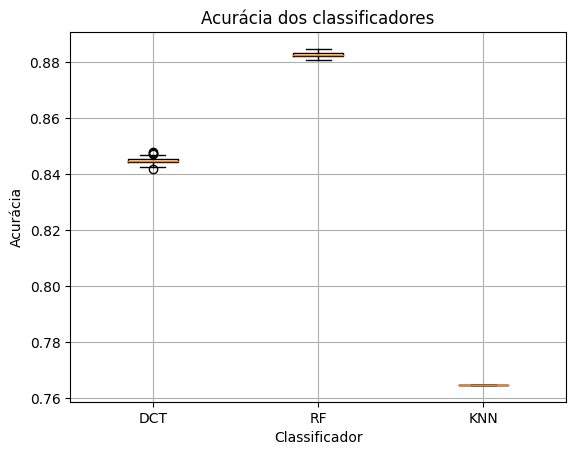

In [38]:
plt.boxplot([classificador['acuracias'] for classificador in classificadores],
            labels=[classificador['nome'] for classificador in classificadores])
plt.grid()
plt.title('Acurácia dos classificadores')
plt.ylabel('Acurácia')
plt.xlabel('Classificador')
plt.show()

# Foi azar?

O gráfico mostra que o classificador Random Forest apresenta uma maior acurácia, mas para analisar se os resultados são estatísticamente relevantes dos outros é usado o teste de Wilcoxon, que analisa se 2 grupos de amostras são estatísticamente diferentes.

In [39]:
from scipy.stats import wilcoxon


def avaliar_hipotese_nula(classificador_1, classificador_2):
    _, p_valor = wilcoxon(classificador_1['acuracias'], classificador_2['acuracias'])
    if p_valor > 0.05:
        print(f'Não há diferença estatística entre os classificadores {classificador_1["nome"]} e {classificador_2["nome"]}')
    else:
        print(f'Há diferença estatística entre os classificadores {classificador_1["nome"]} e {classificador_2["nome"]}')

avaliar_hipotese_nula(classificadores[0], classificadores[1])
avaliar_hipotese_nula(classificadores[0], classificadores[2])
avaliar_hipotese_nula(classificadores[1], classificadores[2])

Há diferença estatística entre os classificadores DCT e RF
Há diferença estatística entre os classificadores DCT e KNN
Há diferença estatística entre os classificadores RF e KNN


Por conta disso, podemos afirmar que RF é superior aos outros modelos (pois a média das acurácias é maior) e que as diferenças entre eles são estatísticamente relevantes (pelo teste de Wilcoxon com valor p menor a 0.05).

# Testando no conjunto do teste

In [40]:
x_treino.shape

(35883, 49)

In [41]:
x_val.shape

(8971, 49)

In [42]:
# Concatenate the training and validation sets: x_train_all]
x_train_all = np.concatenate((x_treino, x_val), axis=0)
x_train_all.shape

(44854, 49)

In [43]:
for classificador in classificadores:
    classificador['acuracia-test'] = accuracy_score(y_teste, classificador['classificador'].fit(np.concatenate((x_treino, x_val), axis=0), np.concatenate((y_treino, y_val), axis=0)).predict(x_teste))

In [44]:
print(tabulate(classificadores, headers='keys', tablefmt='psql'))

+--------+---------------------------------------------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Já testando no conjunto do teste que nunca foi visto, dá para perceber que realmente RF apresenta uma maior acurácia